In [419]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [420]:
import os
import io
import six.moves.urllib as urllib
import sys
import json
import tarfile
import zipfile
from typing import List


from PIL import Image, ImageDraw2, ImageDraw, ImageFont
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf


from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

os.environ["CUDA_VISIBLE_DEVICES"] = ""
sys.path.insert(0, "../")

from mystique.initial_setups import set_graph_and_tensors
from mystique.predict_card import PredictCard
from mystique.detect_objects import ObjectDetection
from mystique.utils import plot_results, COLORS
from mystique import config

# This is needed to display the images.
import matplotlib.pyplot as plt
from matplotlib import pylab, figure

%matplotlib inline

In [47]:
def predict_bbox(img_path) -> np.array:
    """
    Predict the bounding boxes, class label and draw the bbox
    on the original image.
    """
    img = Image.open(img_path)
    img_np = np.asarray(img)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    img_np_copy = img_np.copy()
    object_detection = ObjectDetection()
    
    output, category = object_detection.get_objects(img_np, img)
    # google models wants ymin, xmin, ymax, xmax format.
    # output["detection_boxes"] = output["detection_boxes"][:, [1, 0, 3, 2]]
    
    _imgbuf = plot_results(img,
                 output["detection_classes"],
                 output["detection_scores"],
                 output["detection_boxes"]
                )
    return _imgbuf

In [88]:
img_path = "/home/haridas/projects/AdaptiveCards-ro/source/pic2card/app/assets/samples/8.png"
a = Image.open(predict_bbox(img_path))
img_path = "/home/haridas/projects/AdaptiveCards-ro/source/pic2card/app/assets/samples/9.png"
b = Image.open(predict_bbox(img_path))

In [496]:
# np.random.choice(range(1000))

# Better Layout setting based on object coordinate.

In [738]:
img_path = "/home/haridas/projects/mystique/data/templates_test_data/2.png"
img1 = Image.open(img_path)

In [688]:
# od_result = {k : np.array(v) for k, v in json.loads(open("../od_result_100.json").read()).items()}
# img_path = "/home/haridas/projects/mystique/data/templates_test_data/1.png"
# img = Image.open(img_path)

od_result = {k : np.array(v) for k, v in json.loads(open("../od_result_18.json").read()).items()}
img_path = "/home/haridas/projects/mystique/data/train_and_test-2020-Jun-05-coco/train/18.png"
img = Image.open(img_path)

In [739]:
# Image.open(plot_results(img,
#              scores=od_result["detection_scores"],
#              boxes=od_result["detection_boxes"],
#              classes=od_result["detection_classes"]))

In [737]:
box_df = pd.DataFrame(
    [(ind, *i) for ind, i in enumerate(od_result['detection_boxes'])],
    columns=["ind", "x1", "y1", "x2", "y2"]
)
box_df["class"] = od_result["detection_classes"]

In [741]:
def bbox_area(x1, y1, x2, y2):
    return abs(x2 - x1) * abs(y2 - y1)


def min_iou(box1, box2, threshold=0.9):
    """check box1 and box2 intersecting and its area is
        not greater than the 90% of min area of box1 and box2.
    """
    x1, y1, x2, y2 = box1
    xx1, yy1, xx2, yy2 = box2
    
    x = max([x1, xx1])
    y = max([y1, yy1])
    xx = min([x2, xx2])
    yy = min([y2, yy2])
    
    # No intersection at all.
    if x >= xx or y >= yy:
        return False
    
    box = [x, y, xx, yy]
    min_box_area = min([bbox_area(*box1), bbox_area(*box2)])
    #print(f"=> {bbox_area(*box)} : {min_box_area * threshold} , {box1} : {box2} : {box}")
    return bbox_area(*box) >= threshold * min_box_area


def check_same_row(box1, box2):
    "Check box1 and box2 are in same row."
    x1, y1, x2, y2 = box1
    xx1, yy1, xx2, yy2 = box2
    return min([y2, yy2]) > max([y1, yy1])


def check_same_col(box1, box2):
    "Two boxes are aligned x-axis or not"
    x1, y1, x2, y2 = box1
    xx1, yy1, xx2, yy2 = box2
    return min([x2, xx2]) > max([x1, xx1])


def merge_box_coords(box1, box2):
    "Merge two box coordinates and create the enclosed box coordinate."
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    return [x1, y1, x2, y2]
    

def collect_rows(bbox_list):
    """
    @param bbox_list: sorted bbox_list with "y1" and "y2", also
                      includes item label.
    """
    rows = []
    row = []
    bbox_list = sorted(bbox_list, key=lambda x: x[1][1])
    while bbox_list:
        label, box = bbox_list.pop(0)
        if not row:
            row.append((label, box))
            box_coord = box
            continue
        elif check_same_row(box_coord, box):
            row.append((label, box))
            # update the row coordinate
            box_coord = merge_box_coords(box, box_coord)
        else:
            # Found a full row, the new item is part of
            # next element.
            rows.append(parse_row(row))
            row = [(label, box)]
            box_coord = box
    else:
        row and rows.append(parse_row(row))
    return rows


def parse_row(row):
    #time.sleep(1)
    #print(len(row))
    #print (row)
    if len(row) == 1:
        return row[0]
    else:
        item_set = {
            "type": "ItemSet",
            "columns": []
        }
        # Sort items based on x1 axis.
        row = sorted(row, key=lambda x: x[1][0])
        
        #print(row)
        col = []
        has_nested_col = False
        
        while row:
            label, box = row.pop(0)
            #print(f"box poped: {box}")
            if not col:
                col.append((label, box))
                col_coord = box
                continue
            elif check_same_col(col_coord, box):
                # Mark the column has multiple row or not.
                if min_iou(box, col_coord):
                    #print(f"box intersection: box: {box}, col_cord: {col_coord}")
                    has_nested_col = True
                    print("nesting.")
                    
                col.append((label, box))
                col_coord = merge_box_coords(col_coord, box)
                #print(f"box: {box}, col Cord: {col_coord}")
            else:
                # Reached end of current column.
                #print("----- found a col ----")
                if has_nested_col:
                    item_set["columns"].append(collect_rows(col))
                    #item_set["columns"].append(col)
                else:
                    item_set["columns"].append(col)
                
                col = [(label, box)]
                col_coord = box
                # Reset for next column aggregation.
                has_nested_col = False
        else:
            # Handle last column
            if has_nested_col:
                item_set["columns"].append(collect_rows(col))
                #item_set["columns"].append(col)
            else:
                item_set["columns"].append(col)
        return item_set

In [695]:
# [len(i) for i in collect_rows(bbox_list)]
bbox_list = [(int(t2), t1) for (*t1, t2) in box_df.sort_values(by=["y1", "x1"]).to_numpy()[:, 1:]]

In [742]:
card_layout = collect_rows(bbox_list)
# min_iou(*[i[1] for i in bbox_list[:2]])
# parse_row(bbox_list)

In [752]:
# card_layout.copy?

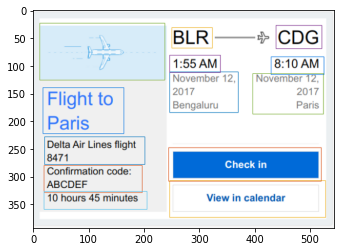

In [693]:
row_sorted = sorted(row, key=lambda x: x[1][0])
plt.figure(figsize=(10, 15))
plt.imshow(Image.open(plot_results(img,
             scores=od_result["detection_scores"],
             boxes=od_result["detection_boxes"],
             classes=od_result["detection_classes"])).resize(img.size))